In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

In [2]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

In [3]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [4]:
# Is it possible that it has memory issues?
# Make is_subset -> False after development is complete.

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order())


/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_4.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/r

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_2.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_1.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/n

In [5]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import beta_utils
from pprint import pprint

all_args = load_models.gen_all_model_args()

beta_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = beta_utils.get_optimal_beta_value(*arg_set)
    
    beta_set[model_title] = round(this_beta, 3)
    
pprint(beta_set)

{'Adult BERT without tags, , +-20 utts context': 3.3,
 'Adult BERT without tags, , same utt only': 3.4,
 'CHILDES BERT with tags, , +-20 utts context': 3.0,
 'CHILDES BERT with tags, , same utt only': 3.1,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.4,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.0,
 'CHILDES BERT without tags, , same utt only': 3.2,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT without tags, older children, same utt only': 3.4,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.1,
 'CHILDES BERT without tags, younger children, same utt only': 3.1,
 'CHILDES unigram without tags, , same utt only': 2.5,
 'Flat prior without tags, , same utt only': 2.5}


In [6]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}

no_unigram = {
 'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , same utt only',
 "CHILDES BERT with tags, , +-20 utts context",
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
}

tags_context_only = {
 "CHILDES BERT with tags, , +-20 utts context",
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, younger children, +-20 utts context',
}

scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(tags_context_only)].copy()


In [7]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [8]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT with tags, , +-20 utts context",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT with tags, , same utt only",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, , +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, , same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [9]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

                     model prior_surprisal
1         CDL+Context+Tags        3.321190
2              CDL+Context        3.424069
3   CDL+Older+Context+Tags        3.388120
4        CDL+Older+Context        3.502749
5 CDL+Younger+Context+Tags        3.487031
6      CDL+Younger+Context        3.512024


In [10]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id CDL+Context+Tags  CDL+Context CDL+Older+Context+Tags
1         49676     0.0009260167 0.0007204352           0.0004065618
2         52857     0.0110804634 0.0256987140           0.0046467707
3         60498     0.0001718302 0.0025232614           0.0134188002
4         60499     0.0005986911 0.0008698311           0.0002857940
5         65634     0.1349055618 0.1811656952           0.2467705309
6         65852     0.0875518247 0.0445239507           0.0570895337
  CDL+Older+Context CDL+Younger+Context+Tags CDL+Younger+Context
1      1.806228e-04             5.754528e-04        2.959278e-04
2      1.144458e-02             4.762041e-03        2.059814e-02
3      3.004536e-03             1.845791e-04        4.658899e-04
4      2.468799e-05             6.473048e-05        5.385762e-05
5      2.004428e-01             1.182221e-01        9.350581e-02
6      2.411982e-02             8.565550e-02        1.325952e-02


In [11]:
%%R
model_names = unique(successes_across_time$model)
print(model_names) # Probably because it's not a copy?

# It's still 18 levels -- why?

[1] CDL+Context+Tags         CDL+Context              CDL+Younger+Context+Tags
[4] CDL+Younger+Context      CDL+Older+Context+Tags   CDL+Older+Context       
18 Levels: CDL+Context+Tags CDL+Context CDL+OneUtt+Tags ... UniformPrior


In [12]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in .subset2(x, i, exact = exact) : subscript out of bounds




Error in .subset2(x, i, exact = exact) : subscript out of bounds


### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here -- possibly ask about this; Is probably adaptive?

In [13]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age                    model posterior_surprisal_mean
1  0.5              CDL+Context                1.5797801
2  0.5         CDL+Context+Tags                1.5532536
3  0.5        CDL+Older+Context                0.2270885
4  0.5   CDL+Older+Context+Tags                0.4272493
5  0.5      CDL+Younger+Context                0.0696115
6  0.5 CDL+Younger+Context+Tags                0.2903472
7  1.5              CDL+Context                1.2250830
8  1.5         CDL+Context+Tags                1.1916521
9  1.5        CDL+Older+Context                1.3003037
10 1.5   CDL+Older+Context+Tags                1.2831704
11 1.5      CDL+Younger+Context                1.2197166
12 1.5 CDL+Younger+Context+Tags                1.1886609
13 1.0              CDL+Context                1.5630414
14 1.0         CDL+Context+Tags                1.5900637
15 1.0        CDL+Older+Context                1.8557408
16 1.0   CDL+Older+Context+Tags                1.8518568
17 1.0      CDL+Younger+Context

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,CDL+Context,1.579780,NaN
2,0.5,CDL+Context+Tags,1.553254,NaN
3,0.5,CDL+Older+Context,0.227089,NaN
4,0.5,CDL+Older+Context+Tags,0.427249,NaN
5,0.5,CDL+Younger+Context,0.069611,NaN
6,0.5,CDL+Younger+Context+Tags,0.290347,NaN
7,1.5,CDL+Context,1.225083,0.125771
8,1.5,CDL+Context+Tags,1.191652,0.123495
9,1.5,CDL+Older+Context,1.300304,0.134646
10,1.5,CDL+Older+Context+Tags,1.283170,0.131000


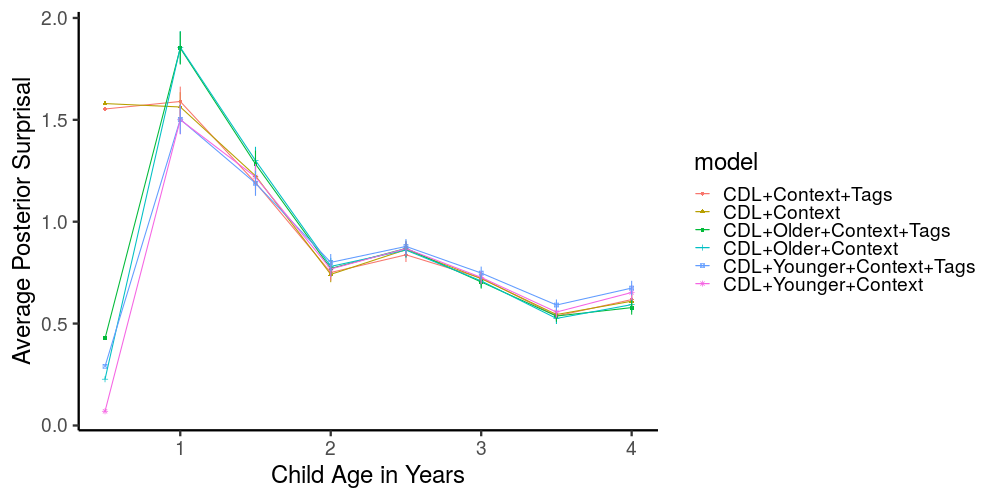

In [14]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [15]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,CDL+Context,8.021802,NaN
2,0.5,CDL+Context+Tags,4.013714,NaN
3,0.5,CDL+Older+Context,2.001964,NaN
4,0.5,CDL+Older+Context+Tags,2.185042,NaN
5,0.5,CDL+Younger+Context,1.135198,NaN
6,0.5,CDL+Younger+Context+Tags,1.385446,NaN
7,1.5,CDL+Context,3.846919,0.111804
8,1.5,CDL+Context+Tags,3.626939,0.108506
9,1.5,CDL+Older+Context,4.055461,0.116741
10,1.5,CDL+Older+Context+Tags,3.852958,0.109578


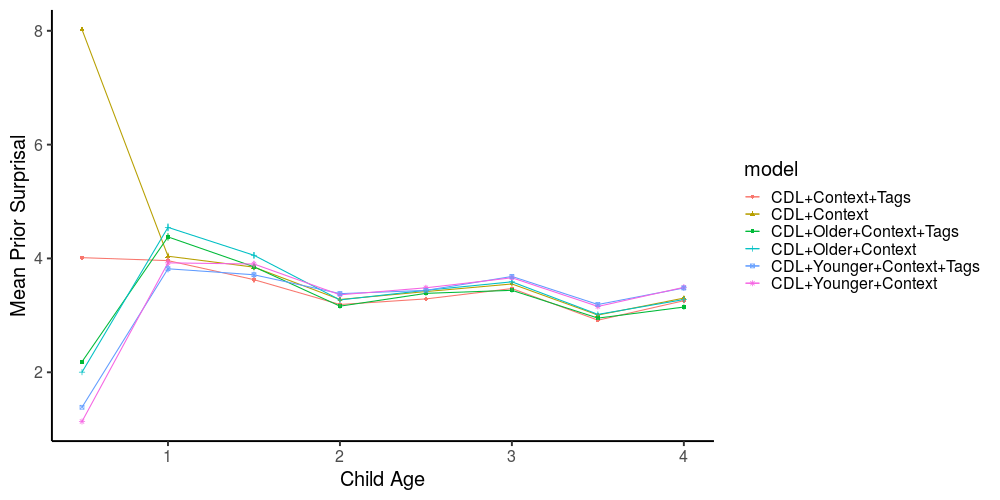

In [16]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model),
) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model, shape=model)) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [17]:
scores_across_time_short.set.value_counts()

success    49404
failure    15582
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [18]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,CDL+Context,failure,0.548938,NaN
2,0.5,CDL+Context,success,1.328204,NaN
3,0.5,CDL+Context+Tags,failure,0.641691,NaN
4,0.5,CDL+Context+Tags,success,1.468022,NaN
5,0.5,CDL+Older+Context,failure,0.806107,NaN
...,...,...,...,...,...
92,4.0,CDL+Older+Context+Tags,success,0.512517,0.026080
93,4.0,CDL+Younger+Context,failure,2.248492,0.432883
94,4.0,CDL+Younger+Context,success,0.583139,0.027645
95,4.0,CDL+Younger+Context+Tags,failure,2.275196,0.441842


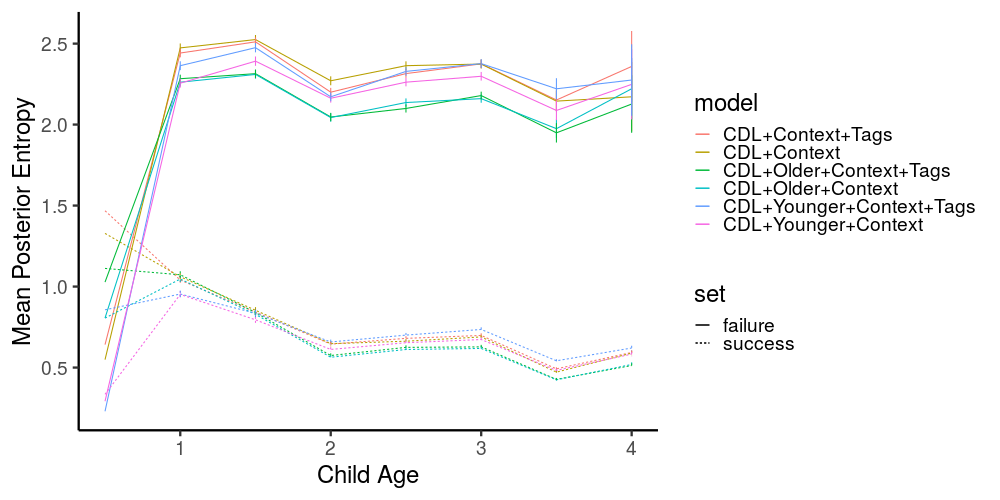

In [19]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [20]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [21]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age                    model     gain gain_sem comparison age_in_months
1 0.5              CDL+Context 18.63246       NA  posterior             6
2 0.5         CDL+Context+Tags 19.44020       NA  posterior             6
3 0.5        CDL+Older+Context 22.77205       NA  posterior             6
4 0.5   CDL+Older+Context+Tags 21.76418       NA  posterior             6
5 0.5      CDL+Younger+Context 24.01682       NA  posterior             6
6 0.5 CDL+Younger+Context+Tags 21.53149       NA  posterior             6


In [22]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

[1] age           model         gain          gain_sem      comparison   
[6] age_in_months
<0 rows> (or 0-length row.names)


In [23]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

R[write to console]: Error in `[<-.data.frame`(`*tmp*`, "comparison", value = "perceptual data") : 
  replacement has 1 row, data has 0




Error in `[<-.data.frame`(`*tmp*`, "comparison", value = "perceptual data") : 
  replacement has 1 row, data has 0


In [24]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

R[write to console]: Error in kls_with_uniform_prior$comparison[kls_with_uniform_prior$comparison ==  : 
  object 'kls_with_uniform_prior' not found




Error in kls_with_uniform_prior$comparison[kls_with_uniform_prior$comparison ==  : 
  object 'kls_with_uniform_prior' not found


In [25]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

R[write to console]: Error in subset(kls_with_uniform_prior, age_in_months > 6) : 
  object 'kls_with_uniform_prior' not found




Error in subset(kls_with_uniform_prior, age_in_months > 6) : 
  object 'kls_with_uniform_prior' not found


# 12 Posterior Probability as a function of edit distance

In [37]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
geom_line(data=ref_dfs, aes(x=upstream_pointer,y=normalized_var, linetype=line_model),colour='gray', alpha=.25) +
facet_wrap(~model)

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

R[write to console]: Error in fortify(data) : object 'ref_dfs' not found

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Ignoring unknown aesthetics: shape 

R[write to console]: 2: Ignoring unknown aesthetics: shape 

R[write to console]: 3: Ignoring unknown aesthetics: shape 

R[write to console]: 4: Ignoring unknown aesthetics: shape 




Error in fortify(data) : object 'ref_dfs' not found


In [27]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


[1] edit_distance                model                       
[3] mean_posterior_surprisal     mean_posterior_surprisal_sem
[5] high                         low                         
[7] unigram_prior_prob           multiplier                  
<0 rows> (or 0-length row.names)


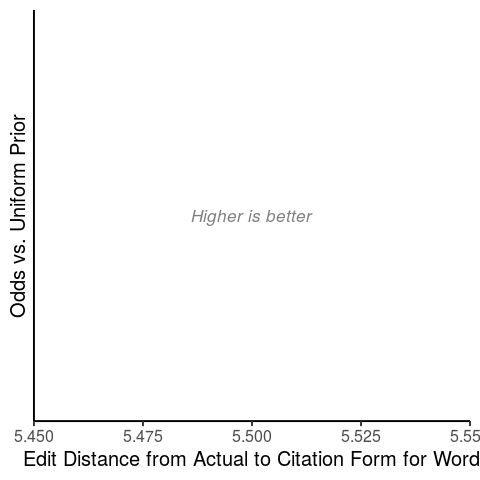

In [28]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

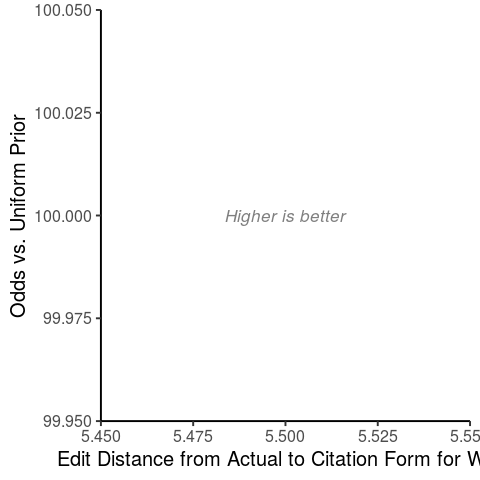

In [29]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [30]:
%%R
library(plotROC)

In [31]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 49404 15582


In [32]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "CDL+Context+Tags"         "CDL+Context"             
[3] "CDL+Younger+Context+Tags" "CDL+Younger+Context"     
[5] "CDL+Older+Context+Tags"   "CDL+Older+Context"       


In [33]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [34]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [35]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "CDL+Context (AUC = 0.87)" "CDL+Context (AUC = 0.87)"
 [3] "CDL+Context (AUC = 0.87)" "CDL+Context (AUC = 0.87)"
 [5] "CDL+Context (AUC = 0.87)" "CDL+Context (AUC = 0.87)"
 [7] "CDL+Context (AUC = 0.87)" "CDL+Context (AUC = 0.87)"
 [9] "CDL+Context (AUC = 0.87)" "CDL+Context (AUC = 0.87)"


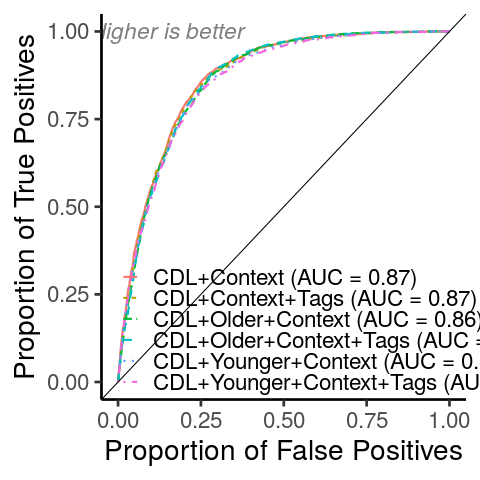

In [36]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    